In [85]:
import random
import json, pickle
import re
import os

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent


In [86]:
import sys
sys.path.append(str(WORK_DIR))
from src.datasets import STARDataset
from src import prompt_formatters
from src.STAR_utils.visualization_tools import vis_utils as qaviz


In [87]:
RAW_VIDEO_DIR = Path(WORK_DIR / 'data/datasets/action-genome/Charades_v1_480/')
RAW_FRAME_DIR = Path(WORK_DIR / 'data/datasets/action-genome/frames/')
ANNOTATION_DIR = Path(WORK_DIR / 'src/STAR_utils/annotations/STAR_classes/')
FPS = pickle.load(open(ANNOTATION_DIR / 'video_fps','rb'))

SAVE_VIDEO_DIR = Path(WORK_DIR / "experiments/video_dump")


# Experiment - Deepseek-R1-Qwen3-32b
 
Analysis of the performance of deepseek-r1 based on qwen32b on the QA task with the generated stsg as input.

**Parameters:**
- model: 
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [88]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [89]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v3.txt", 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives. 

In answering the question please be sure to operate according to the following guidlines:
1. Question Interpretation: Clearly state what the question is asking
2. STSG Analysis: Carefully examine the spatial and temporal relationships in the scene graph
3. Alternative Evaluation: For each option (A, B, C, D), explain whether it matches the STSG evidence
4. Reasoning: Provide clear logical step by step reasoning leading to your conclusion
5. Conclusion: Declare the logical conclusion to your reasoning in the above step
6. Consistency Check: B

In [90]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/auto_reply_ZS_CoT.txt", 'r') as f:
    reply = f.read()

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\



Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [91]:
ground_truth = []

with open(WORK_DIR / 'data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [92]:
predictions = []
with open(WORK_DIR / 'outputs/responses_on_small_val_deepseek-r1-qwen32_20250612_11:27:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df = predictions_df.drop_duplicates(subset=['id'])
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Feasibility_T5_102,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_860,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_556,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_2539,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T4_1253,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Sequence_T4_4180,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T6_3755,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T5_2398,"[{'role': 'user', 'content': 'Please carefully..."


In [93]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Feasibility_T5_102,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_860,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T2_556,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T1_2539,"[{'role': 'user', 'content': 'Please carefully..."
Prediction_T4_1253,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Sequence_T4_4180,"[{'role': 'user', 'content': 'Please carefully..."
Sequence_T6_3755,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T5_2398,"[{'role': 'user', 'content': 'Please carefully..."


In [94]:
predictions_df['reasoning'] = predictions_df['chat_history'].apply(lambda x: x[1]['content'])
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [95]:
predictions_df['reasoning'].iloc[0:5] 


id
Feasibility_T5_102    <think>\nOkay, so I need to figure out which o...
Feasibility_T2_860    <think>\nOkay, so I need to figure out what el...
Feasibility_T2_556    <think>\nOkay, so I need to figure out what el...
Prediction_T1_2539    <think>\nOkay, so I need to figure out what th...
Prediction_T4_1253    <think>\nOkay, so I'm trying to figure out whi...
Name: reasoning, dtype: object

In [96]:
predictions_df.iloc[0]['chat_history']


[{'role': 'user',
  'content': 'Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:\n\n<STSG>\n\nFrame 0:\n\nwoman ---- looking_at ---- vertical_post\nvertical_post ---- positioned_on ---- white_wall\nwhite_wall ---- behind ---- woman\nwoman ---- in_front_of ---- dark_blue_fabric\ndark_blue_fabric ---- hanging_from ---- white_wall\ndark_blue_fabric ---- below ---- smaller_dark_blue_fabric\nsmaller_dark_blue_fabric ---- hanging_from ---- white_wall\ndark_blue_fabric ---- covering ---- white_wall\nvertical_post ---- positioned_on ---- white_wall\nwhite_wall ---- supporting ---- dark_blue_fabric\nwoman ---- holding ---- dark_blue_fabric (implied, based on pose)\ndark_blue_fabric ---- draped_over ---- white_wall\n\nFrame 1:\n\nwoman ---- wearing ---- dress\ndress ---- draped_over ---- feet\nwoman ---- holding ---- bag\nbag ---- located_in ---- hand\nbag ---- colored ---- dark_color\nwoman ---- standing_in

In [97]:
a = predictions_df['answer'].iloc[0]
print(a)


<think>
Okay, so I'm trying to figure out which object the woman can throw after walking through the doorway based on the given Spatio-Temporal Scene Graph (STSG). Let's break this down step by step.

First, I need to understand what each frame shows. 

In Frame 0, there's a woman looking at a vertical post that's positioned on a white wall. The white wall is behind her, and she's in front of dark blue fabric hanging from the wall. There's also a smaller piece of dark blue fabric below it. It seems like she might be holding the dark blue fabric based on her pose.

Moving to Frame 1, the woman is wearing a dress that's draped over her feet. She's holding a bag in her hand, which is dark-colored. She's standing in front of a pole that extends into a light-colored wall. The pole is in the background, and she's looking at it. There's also mention of her casting a shadow on the wall.

In Frame 2, the woman is wearing jeans made of denim and holding a backpack on her shoulder. She's also wea

In [98]:
pattern = r'{[\"\']answer[\"\']:\s*(.*)}$'
res = re.match(pattern, a, re.MULTILINE)
res


In [99]:
predictions_df['answer'].str.findall(r'{[\"\']answer[\"\']:\s*(.*)}$')


id
Feasibility_T5_102                      ["A. The bag"]
Feasibility_T2_860            ["C. Close the window."]
Feasibility_T2_556     ["B. Open the closet/cabinet."]
Prediction_T1_2539            ["D. Tidy up the table"]
Prediction_T4_1253                    ["C. The shoe."]
                                    ...               
Sequence_T4_4180              ["B. Took the sandwich"]
Sequence_T6_3755                      ["C. Put down."]
Feasibility_T5_2398                  ["B. The laptop"]
Prediction_T1_2030          ["B. Tidy up the blanket"]
Interaction_T1_8484                   ["C. The shoe."]
Name: answer, Length: 939, dtype: object

## Text preprocessing

In [100]:
pattern = r'{[\"\']answer[\"\']:\s*(.*)}$'
# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.contains(pattern)
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 939
Answers following JSON template: 939
Percentage following JSON template: 100.00%


/tmp/ipykernel_75245/1414218124.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  json_mask = predictions_df['answer'].str.contains(pattern)


In [101]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [102]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(pattern, x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Feasibility_T5_102                      "A. The bag"
Feasibility_T2_860            "C. Close the window."
Feasibility_T2_556     "B. Open the closet/cabinet."
Prediction_T1_2539            "D. Tidy up the table"
Prediction_T4_1253                    "C. The shoe."
                                   ...              
Sequence_T4_4180              "B. Took the sandwich"
Sequence_T6_3755                      "C. Put down."
Feasibility_T5_2398                  "B. The laptop"
Prediction_T1_2030          "B. Tidy up the blanket"
Interaction_T1_8484                   "C. The shoe."
Name: answer, Length: 939, dtype: object

### Applying changes

In [103]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


Look for answer in the form \w. \w+ remove the initial lettering
replace fullstop with empty
lower
strip


In [104]:
predictions_df['answer']


id
Feasibility_T5_102                      "A. The bag"
Feasibility_T2_860            "C. Close the window."
Feasibility_T2_556     "B. Open the closet/cabinet."
Prediction_T1_2539            "D. Tidy up the table"
Prediction_T4_1253                    "C. The shoe."
                                   ...              
Sequence_T4_4180              "B. Took the sandwich"
Sequence_T6_3755                      "C. Put down."
Feasibility_T5_2398                  "B. The laptop"
Prediction_T1_2030          "B. Tidy up the blanket"
Interaction_T1_8484                   "C. The shoe."
Name: answer, Length: 939, dtype: object

In [105]:
ans_regex_pattern =  r'^[\"\'](?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)[\"\']'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 858
91.37% of the total

Only 81 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_75245/3993337925.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [106]:
predictions_df.loc[~contains_answer, 'answer']


id
Feasibility_T4_78      "None of the alternatives can be confirmed bas...
Prediction_T4_402      "None of the alternatives can be determined fr...
Prediction_T3_881      "None of the objects (A-D) are mentioned in th...
Interaction_T4_2906    "None of the alternatives (A-D) are supported ...
Prediction_T2_559      "Insufficient information to determine the act...
                                             ...                        
Interaction_T4_1656    "None of the above options are supported by th...
Sequence_T1_3674                                     "None of the above"
Interaction_T1_3198    "None of the above options were opened accordi...
Interaction_T4_2243    "None of the alternatives are supported by the...
Interaction_T2_608     "None of the alternatives are supported by the...
Name: answer, Length: 81, dtype: object

In [82]:
len(set(predictions_df.index))


939

## Extract answers

In [109]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_df['reasoning'] = predictions_df['reasoning']
ans_gen_stsg_df = ans_df
ans_gen_stsg_df


,text,reasoning
id,,
Feasibility_T5_102,the bag.,"<think>\nOkay, so I need to figure out which o..."
Feasibility_T2_860,close the window.,"<think>\nOkay, so I need to figure out what el..."
Feasibility_T2_556,open the closet/cabinet.,"<think>\nOkay, so I need to figure out what el..."
Prediction_T1_2539,tidy up the table.,"<think>\nOkay, so I need to figure out what th..."
Prediction_T4_1253,the shoe.,"<think>\nOkay, so I'm trying to figure out whi..."
...,...,...
Sequence_T4_4180,took the sandwich.,"<think>\nOkay, so I need to figure out what ha..."
Sequence_T6_3755,put down.,"<think>\nOkay, so I'm trying to figure out wha..."
Feasibility_T5_2398,the laptop.,"<think>\nOkay, so I need to figure out which o..."


In [110]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 858 entries, Feasibility_T5_102 to Interaction_T1_8484
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       858 non-null    object
 1   reasoning  858 non-null    object
dtypes: object(2)
memory usage: 20.1+ KB


In [119]:
# Inner join - keeps only indices present in both series

ans_df_tmp = ans_df.rename(columns={'text': 'pred_text'})
eval_df = gt_df.join(
    ans_df_tmp, 
    how='inner' # we account also for samples without answers
)

eval_df['text'] = eval_df['text'].str.lower()
eval_df['pred_text'] = eval_df['pred_text'].str.lower()
eval_df.shape


(858, 6)

In [120]:
eval_df


,question,choices,num,text,pred_text,reasoning
id,,,,,,
Interaction_T1_70,Which object was thrown by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,the shoe.,the shoe.,"<think>\nOkay, so I need to figure out which o..."
Interaction_T1_100,Which object was tidied up by the person?,"{'0': 'The table.', '1': 'The towel.', '2': 'T...",3,the blanket.,the clothes.,"<think>\nOkay, so I need to figure out which o..."
Interaction_T1_101,Which object was put down by the person?,"{'0': 'The cup/glass/bottle.', '1': 'The box.'...",1,the box.,the bag.,"<think>\nOkay, so I need to figure out which o..."
Interaction_T1_104,Which object was taken by the person?,"{'0': 'The clothes.', '1': 'The cup/glass/bott...",0,the clothes.,the book.,"<think>\nOkay, so I need to figure out which o..."
Interaction_T1_148,Which object was sat on by the person?,"{'0': 'The floor.', '1': 'The table.', '2': 'T...",0,the floor.,the floor.,"<think>\nOkay, so I need to figure out which o..."
...,...,...,...,...,...,...
Feasibility_T6_1403,What is the person able to do after putting do...,"{'0': 'Sit on the sofa/couch.', '1': 'Take the...",3,throw the blanket.,take the shoe.,"<think>\nOkay, so I need to figure out what th..."
Feasibility_T6_1412,What is the person able to do after walking th...,"{'0': 'Put down the box.', '1': 'Hold the book...",1,hold the book.,sit at the table.,"<think>\nOkay, so I need to figure out what th..."
Feasibility_T6_1413,What is the person able to do after holding th...,"{'0': 'Wash the table.', '1': 'Open the box.',...",3,open the book.,open the book.,"<think>\nOkay, so I need to figure out what th..."


In [121]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [124]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")
    
    print()
    total = eval_df.shape[0]
    acc = acc_fn(eval_df)
    print(f"{'Average':<15}{total:^15}{acc:^10.2%}")


In [125]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          210        47.62%  
Sequence             245        46.12%  
Prediction           205        44.39%  
Feasibility          198        37.88%  

Average              858        44.17%  


In [126]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        8.76%   
Sequence            3586        6.83%   
Prediction           624        32.85%  
Feasibility          490        40.41%  
Overall             7098        12.09%  


## Loading predicted answers - ground truth stsg as input

In [27]:
predictions = []
with open(WORK_DIR / 'outputs/responses_gemma3:4b_20250323_20:38:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df



,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [28]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [29]:
predictions_df['reasoning'] = predictions_df['chat_history'].apply(lambda x: x[1]['content'])
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [30]:
predictions_df['reasoning'].iloc[0:5] 


id
Interaction_T1_13    Okay, let's analyze the Spatio-Temporal Scene ...
Interaction_T1_14    Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_31    Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_32    Let's analyze the STSG to determine which obje...
Interaction_T1_40    Let's analyze the STSG to determine which obje...
Name: reasoning, dtype: object

In [31]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_13     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_14    ```json\n{"answer": "C. The clothes."}\n```
Interaction_T1_31     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_32       ```json\n{"answer": "B. The shoe."}\n```
Interaction_T1_40    ```json\n{"answer": "C. The blanket."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [32]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7097
Percentage following JSON template: 99.99%


In [33]:
predictions_df.loc[~json_mask, 'answer']


id
Prediction_T4_1351    ```json\n{"answer": "Therefore the final answe...
Name: answer, dtype: object

In [34]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_13          {"answer": "C. The clothes"}
Interaction_T1_14         {"answer": "C. The clothes."}
Interaction_T1_31          {"answer": "C. The clothes"}
Interaction_T1_32            {"answer": "B. The shoe."}
Interaction_T1_40         {"answer": "C. The blanket."}
                                     ...               
Feasibility_T6_1453    {"answer": "A. Wash the table."}
Feasibility_T6_1454     {"answer": "A. Take the towel"}
Feasibility_T6_1455    {"answer": "B. Wash the table."}
Feasibility_T6_1456    {"answer": "D. Wash the table."}
Feasibility_T6_1468      {"answer": "B. Hold the food"}
Name: answer, Length: 7098, dtype: object

### Applying changes

In [35]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [ ]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,reasoning,answer
id,,,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully...","Okay, let's analyze the Spatio-Temporal Scene ...",C. The clothes
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the Spatio-Temporal Scene Graph ...,C. The clothes.
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the Spatio-Temporal Scene Graph ...,C. The clothes
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the STSG to determine which obje...,B. The shoe.
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the STSG to determine which obje...,C. The blanket.
...,...,...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the Spatio-Temporal Scene Graph ...,A. Wash the table.
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the scene graph to understand th...,A. Take the towel
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully...",Let's analyze the STSG to determine what the p...,B. Wash the table.


In [37]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do NOT contain the answer in the response with the specified format")


Answer following the template: 6778
95.49% of the total

Only 320 samples do NOT contain the answer in the response with the specified format


/tmp/ipykernel_3175375/1875602683.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [38]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_198     None of the alternatives are correct based on ...
Interaction_T1_1255                None of the alternatives are correct.
Interaction_T1_1369                None of the alternatives are correct.
Interaction_T1_1671    None of the alternatives can be determined fro...
Interaction_T1_2509    None of the alternatives are correct based on ...
                                             ...                        
Feasibility_T6_448                                     None of the above
Feasibility_T6_1063    None of the alternatives are correct. The grap...
Feasibility_T6_1091    None of the alternatives are correct based on ...
Feasibility_T6_1153    None of the alternatives are correct based on ...
Feasibility_T6_1344    None of the provided alternatives accurately d...
Name: answer, Length: 320, dtype: object

## Extract answers

In [ ]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_df['reasoning'] = predictions_df['reasoning']
ans_gt_stsg_df = ans_df
ans_gt_stsg_df


,text,reasoning
id,,
Interaction_T1_13,the clothes.,"Okay, let's analyze the Spatio-Temporal Scene ..."
Interaction_T1_14,the clothes.,Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_31,the clothes.,Let's analyze the Spatio-Temporal Scene Graph ...
Interaction_T1_32,the shoe.,Let's analyze the STSG to determine which obje...
Interaction_T1_40,the blanket.,Let's analyze the STSG to determine which obje...
...,...,...
Feasibility_T6_1453,wash the table.,Let's analyze the Spatio-Temporal Scene Graph ...
Feasibility_T6_1454,take the towel.,Let's analyze the scene graph to understand th...
Feasibility_T6_1455,wash the table.,Let's analyze the STSG to determine what the p...


In [ ]:
ans_gen_stsg_df


,text,reasoning
id,,
Interaction_T1_14,the blanket.,"Okay, let's analyze the scene graph and answer..."
Interaction_T1_31,the pillow.,"Okay, let's analyze the scene graph and answer..."
Interaction_T1_32,the blanket.,"Okay, let's analyze the scene graph and answer..."
Interaction_T1_40,the closet/cabinet.,"Okay, let's analyze the scene graph and answer..."
Interaction_T1_71,the paper/notebook.,"Okay, let's analyze the scene graph and answer..."
...,...,...
Feasibility_T6_1104,sit on the floor.,"Okay, let's analyze the scene graph and answer..."
Feasibility_T6_1263,take the food.,"Okay, let's analyze the scene graph and answer..."
Feasibility_T6_1267,put down the paper/notebook.,"Okay, let's analyze the scene graph and answer..."


In [41]:
# Inner join - keeps only indices present in both series

ans_gt_stsg_df.rename(columns={'text': 'gt_stsg_pred'}, inplace=True)
ans_gen_stsg_df.rename(columns={'text': 'gen_stsg_pred'}, inplace=True)

ans_gt_stsg_df.rename(columns={'reasoning': 'gt_stsg_reasoning'}, inplace=True)
ans_gen_stsg_df.rename(columns={'reasoning': 'gen_stsg_reasoning'}, inplace=True)

eval_df = gt_df \
    .join(
        ans_gt_stsg_df, 
        how='inner' # we account also for samples without answer
    ).join(
        ans_gen_stsg_df, 
        how='inner'
    )

eval_df['text'] = eval_df['text'].str.lower()
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1203 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question            1203 non-null   object
 1   choices             1203 non-null   object
 2   num                 1203 non-null   string
 3   text                1203 non-null   string
 4   gt_stsg_pred        1203 non-null   object
 5   gt_stsg_reasoning   1203 non-null   object
 6   gen_stsg_pred       1203 non-null   object
 7   gen_stsg_reasoning  1203 non-null   object
dtypes: object(6), string(2)
memory usage: 84.6+ KB


In [42]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [43]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    avg = 0
    previous_total = 0
    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    avg += acc
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")
    
    print()
    print(f"{'Average':<15}{eval_df.shape[0]:^15}{avg:^10.2%}")


### Accuracy with the ground truth STSG as input

In [44]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'gt_stsg_pred']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1140        65.18%  
Sequence              6         83.33%  
Prediction            0          nan%   
Feasibility          57         61.40%  

Average             1203         nan%   


/tmp/ipykernel_3175375/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


### Accuracy with the generated STSG as input

In [ ]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'gen_stsg_pred']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1140        44.56%  
Sequence              6         50.00%  
Prediction            0          nan%   
Feasibility          57         40.35%  

Average             1203         nan%   


/tmp/ipykernel_3175375/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


The question of type `Sequence` are so few that a statistical analysis would be pointless, let's discard them:

In [46]:
eval_df = eval_df.loc[eval_df.index.str.match(r'^[^S]')]
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1197 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question            1197 non-null   object
 1   choices             1197 non-null   object
 2   num                 1197 non-null   string
 3   text                1197 non-null   string
 4   gt_stsg_pred        1197 non-null   object
 5   gt_stsg_reasoning   1197 non-null   object
 6   gen_stsg_pred       1197 non-null   object
 7   gen_stsg_reasoning  1197 non-null   object
dtypes: object(6), string(2)
memory usage: 84.2+ KB


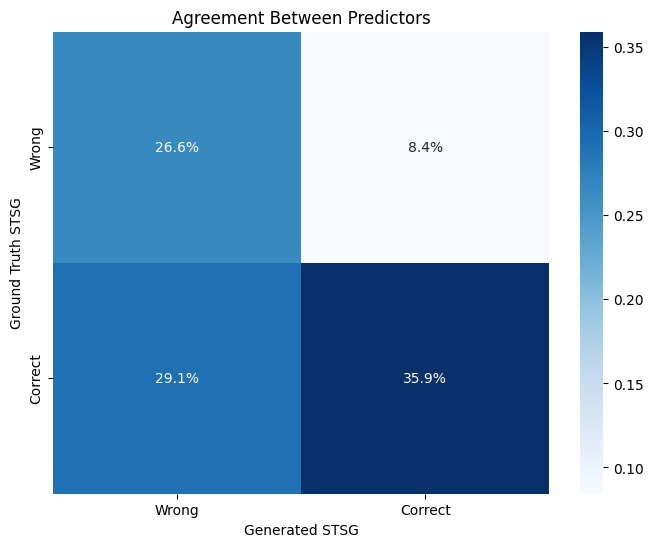

In [ ]:
gt_stsg_correct = (eval_df['text'] == eval_df['gt_stsg_pred']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['gen_stsg_pred']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct'], 
    yticklabels=['Wrong', 'Correct'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


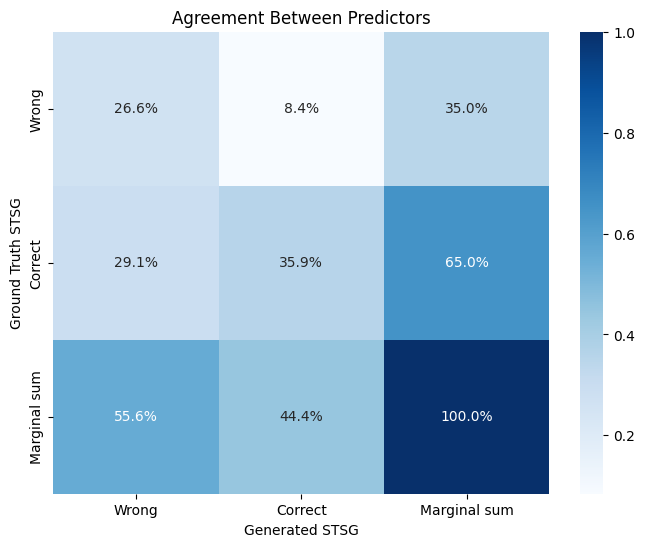

In [ ]:
gt_stsg_correct = (eval_df['text'] == eval_df['gt_stsg_pred']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['gen_stsg_pred']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

extended_matrix = np.zeros((cm.shape[0]+1,cm.shape[1]+1 ))
extended_matrix[:-1, :-1] = cm_norm
extended_matrix[:-1,-1] = cm_norm.sum(axis=1) # sum the rows (i.e. sum passing by columns a[0][i] for i...)
extended_matrix[-1,:-1] = cm_norm.sum(axis=0)
extended_matrix[-1, -1] = 1.0

plt.figure(figsize=(8, 6))
sns.heatmap(
    extended_matrix, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct', 'Marginal sum'], 
    yticklabels=['Wrong', 'Correct', 'Marginal sum'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


In [49]:
wrong_wrong_mask = (gt_stsg_correct == 0) & (gen_stsg_correct == 0)
wrong_wrong_df = eval_df[wrong_wrong_mask]

wrong_but_agree = (wrong_wrong_df['gt_stsg_pred'] == wrong_wrong_df['gen_stsg_pred']).astype(int)


In [50]:
# Ground truth (0 = different wrong predictions, 1 = same wrong prediction)
y_true = np.ones_like(wrong_but_agree)  # (Assuming we want to measure agreement)

# Since we're only checking agreement, we can just count matches vs mismatches
print("Sub-Confusion Matrix for Wrong-Wrong Cases:")
print(pd.crosstab(
    wrong_but_agree,
    columns=['Prediction Agreement'],
    rownames=['Same Wrong Prediction?']
))


Sub-Confusion Matrix for Wrong-Wrong Cases:
col_0                   Prediction Agreement
Same Wrong Prediction?                      
0                                        122
1                                        196


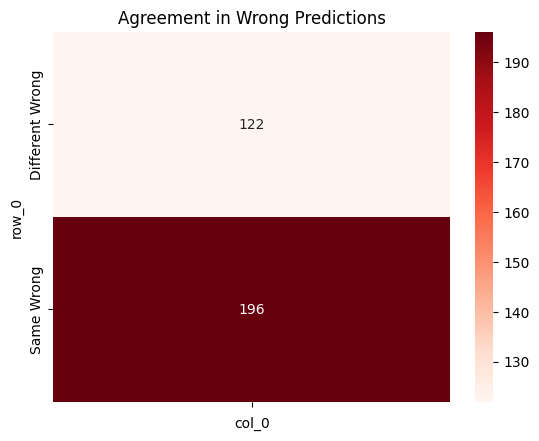

In [ ]:
sns.heatmap(
    pd.crosstab(wrong_but_agree, columns=['']),
    annot=True, fmt='d', cmap='Reds',
    xticklabels=[''],
    yticklabels=['Different Wrong', 'Same Wrong']
)
plt.title('Agreement in Wrong Predictions')
plt.show()


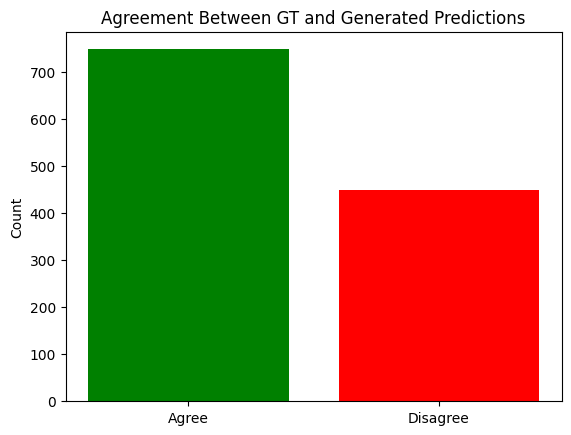

In [ ]:
agreement = np.sum(gt_stsg_correct == gen_stsg_correct)
disagreement = len(gt_stsg_correct) - agreement

plt.bar(['Agree', 'Disagree'], [agreement, disagreement], color=['green', 'red'])
plt.title('Agreement Between GT and Generated Predictions')
plt.ylabel('Count')
plt.show()


## Correct-Correct samples

In [103]:
correct_correct_mask = (gt_stsg_correct == 1) & (gen_stsg_correct == 1)
correct_correct_df = eval_df[correct_correct_mask]

ids = correct_correct_df.index.to_list()
